In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.7 MB/s eta 0:00:00


In [ ]:
!pip install adabelief-pytorch==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
from glob import glob
import json
import requests
import tensorflow as tf
from transformers import BertModel, TFBertModel, TFRobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from adabelief_pytorch import AdaBelief
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm, tqdm_notebook
import shutil
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

여기서 하이퍼 파라미터 BATCH_SIZE, L_RATE 조절.

In [ ]:
# random seed 고정
# 파라미터들 정의.
tf.random.set_seed(2023)
np.random.seed(2023)
BATCH_SIZE = 32
NUM_EPOCHS = 3

L_RATE = 1e-05
MAX_LEN = 70
max_grad_norm=1
log_interval=200
NUM_CORES = os.cpu_count()
device = torch.device("cuda:0")

In [ ]:
#pre-trained된 tokenizer, model 불러오기  
model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-small",num_labels=10)
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-small")

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifi

In [ ]:
#Google Drive 연동 
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/NLP/Data/최종학습데이터세트_병합ver_전처리전단계_0116.csv',encoding = 'utf-8')
#하위 카테고리 drop
data.drop('하위 카테고리',axis = 1,inplace = True)
#label encoding
data['카테고리'] = data['카테고리'].replace(['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],[0,1,2,3,4,5,6,7,8,9])

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

#stratify train-test split
X_data = data['품목명']
y_data = data['카테고리']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2023, stratify=y_data)

In [ ]:
# 정규표현식 통해 전처리 이후 train-valid split 위해 다시 합쳐주기 
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']
#마지막 결과 출력을 위한 test_data 저장.
last_test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
last_test_data.columns = ['품목명','label']

In [ ]:
import re
# 데이터 전처리 
# 괄호(),[],<> 안에 들어가있는 문자들 제거
train_data.replace('\[[^]]*\]', '', regex=True,inplace=True)
train_data.replace('\([^]]*\)', '', regex=True,inplace=True)
train_data.replace('\<[^]]*\>', '', regex=True,inplace=True)

# 특수문자를 띄어쓰기로 대체(특수문자: 영어, 한글, 숫자 제외한 문자들)
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[^A-Za-z0-9가-힣]').sub(' ',x))

# 숫자를 공백(띄어쓰기 없음)으로 대체
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[0-9]').sub('',x))

# 숫자를 공백으로 대체한 후, 중복값 제거
train_data.drop_duplicates(['품목명'], keep = 'first',ignore_index = True, inplace=True)

# 알파벳 길이가 1인 문자 제거
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'(?<=\s)([A-Za-z])(?=\s)').sub(' ',x))

In [ ]:
#stratify trian-valid split 
X_train, X_val, y_train, y_val = train_test_split(train_data['품목명'], train_data['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 2023, 
                                                    stratify = train_data['label'])

In [ ]:
#torch DataLoader를 위한 데이터 변형 
class TransDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          pad_to_max_length = True,
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, "label"])
        sample = (padded_token_list, token_type_id , att_mask, target)
        return sample
    def __len__(self):
        return len(self.df_data)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          pad_to_max_length = True,
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        sample = (padded_token_list, token_type_id , att_mask)
        return sample
    def __len__(self):
        return len(self.df_data)

In [ ]:
#정확도 계산 함수 
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']

valid_data = pd.DataFrame([ x for x in zip(X_val,y_val)])
valid_data.columns = ['품목명','label']


test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
test_data.columns = ['품목명','label']

In [ ]:
#transDataset class 활용 
train_data = TransDataset(train_data)

valid_data = TransDataset(valid_data)

test_data = TestDataset(test_data)

#torch DataLoader 
train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
valid_dataloader = torch.utils.data.DataLoader(valid_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                      num_workers=NUM_CORES)


In [ ]:
#model gpu에 할당
model.to(device)

#optimizer 정의 (AdaBelief 사용.)
optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)

#warmup_ratio
warmup_ratio = 0.1
t_total = len(train_dataloader) * NUM_EPOCHS
warmup_step = int(t_total * warmup_ratio)

#scheduler 정의 (optimizer = Adabelief, warup_step, training_step)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [ ]:
#EPOCH 만큼 학습 시작. 
for e in range(NUM_EPOCHS):
    train_acc = 0.0
    valid_acc = 0.0
    #학습 
    model.train()
    torch.set_grad_enabled(True)
    #train_dataset
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #valid_dataset
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(valid_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        valid_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} valid acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), valid_acc / (batch_id+1)))
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))


preds = [] 
model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-20-c637f46d712a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/11509 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 1 batch id 1 loss 2.319262981414795 train acc 0.078125
epoch 1 batch id 201 loss 1.6374109983444214 train acc 0.2873134328358209
epoch 1 batch id 401 loss 0.9680085182189941 train acc 0.4972334788029925
epoch 1 batch id 601 loss 0.5585739016532898 train acc 0.6013935108153078
epoch 1 batch id 801 loss 0.48368966579437256 train acc 0.6620045255930087
epoch 1 batch id 1001 loss 0.57673180103302 train acc 0.7032030469530469
epoch 1 batch id 1201 loss 0.1688464879989624 train acc 0.7331650707743547
epoch 1 batch id 1401 loss 0.4331648349761963 train acc 0.7549518201284796
epoch 1 batch id 1601 loss 0.5301433801651001 train acc 0.772603060587133
epoch 1 batch id 1801 loss 0.3912329375743866 train acc 0.7863339811215991
epoch 1 batch id 2001 loss 0.46007031202316284 train acc 0.79781984007996
epoch 1 batch id 2201 loss 0.13729746639728546 train acc 0.8077862335302135
epoch 1 batch id 2401 loss 0.28471118211746216 train acc 0.8162484381507705
epoch 1 batch id 2601 loss 0.499284565448761

<ipython-input-20-c637f46d712a>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(valid_dataloader)):


  0%|          | 0/2878 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 1 batch id 1 loss 0.2193267047405243 valid acc 0.953125
epoch 1 batch id 201 loss 0.1356753408908844 valid acc 0.9479944029850746
epoch 1 batch id 401 loss 0.13254031538963318 valid acc 0.9459943890274314
epoch 1 batch id 601 loss 0.3733469247817993 valid acc 0.9468074043261231
epoch 1 batch id 801 loss 0.24004988372325897 valid acc 0.947663077403246
epoch 1 batch id 1001 loss 0.09251783788204193 valid acc 0.9484734015984015
epoch 1 batch id 1201 loss 0.17051635682582855 valid acc 0.9485845129059117
epoch 1 batch id 1401 loss 0.12716828286647797 valid acc 0.9486081370449678
epoch 1 batch id 1601 loss 0.12679645419120789 valid acc 0.9488015302935665
epoch 1 batch id 1801 loss 0.09356958419084549 valid acc 0.9492122431982232
epoch 1 batch id 2001 loss 0.17019808292388916 valid acc 0.9488068465767117
epoch 1 batch id 2201 loss 0.08920389413833618 valid acc 0.9488016810540664
epoch 1 batch id 2401 loss 0.186629518866539 valid acc 0.9492789462723865
epoch 1 batch id 2601 loss 0.213553

  0%|          | 0/11509 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 2 batch id 1 loss 0.08528704196214676 train acc 0.96875
epoch 2 batch id 201 loss 0.09615179151296616 train acc 0.9594993781094527
epoch 2 batch id 401 loss 0.06613308191299438 train acc 0.9578397755610972
epoch 2 batch id 601 loss 0.06387418508529663 train acc 0.9590006239600666
epoch 2 batch id 801 loss 0.08474543690681458 train acc 0.9590941011235955
epoch 2 batch id 1001 loss 0.27739283442497253 train acc 0.9586038961038961
epoch 2 batch id 1201 loss 0.06710876524448395 train acc 0.9589014363030808
epoch 2 batch id 1401 loss 0.11778444051742554 train acc 0.958679068522484
epoch 2 batch id 1601 loss 0.08543100953102112 train acc 0.9591563866333541
epoch 2 batch id 1801 loss 0.09229470044374466 train acc 0.9594756385341477
epoch 2 batch id 2001 loss 0.010949057526886463 train acc 0.9599340954522738
epoch 2 batch id 2201 loss 0.13988856971263885 train acc 0.9600891640163562
epoch 2 batch id 2401 loss 0.16426029801368713 train acc 0.9602314139941691
epoch 2 batch id 2601 loss 0.1

  0%|          | 0/2878 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 2 batch id 1 loss 0.10956429690122604 valid acc 0.984375
epoch 2 batch id 201 loss 0.03728248178958893 valid acc 0.9740360696517413
epoch 2 batch id 401 loss 0.2409050613641739 valid acc 0.9717113466334164
epoch 2 batch id 601 loss 0.19874125719070435 valid acc 0.9713238352745425
epoch 2 batch id 801 loss 0.11640932410955429 valid acc 0.9710127965043696
epoch 2 batch id 1001 loss 0.20700949430465698 valid acc 0.9710601898101898
epoch 2 batch id 1201 loss 0.12458228319883347 valid acc 0.9715731681931724
epoch 2 batch id 1401 loss 0.048541612923145294 valid acc 0.9720400606709493
epoch 2 batch id 1601 loss 0.006157365627586842 valid acc 0.9722536695815116
epoch 2 batch id 1801 loss 0.0887327641248703 valid acc 0.9722289700166574
epoch 2 batch id 2001 loss 0.06546249240636826 valid acc 0.9725137431284357
epoch 2 batch id 2201 loss 0.10780403763055801 valid acc 0.9725195933666515
epoch 2 batch id 2401 loss 0.10544788092374802 valid acc 0.9726350999583507
epoch 2 batch id 2601 loss 0.

  0%|          | 0/11509 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 3 batch id 1 loss 0.0072593423537909985 train acc 1.0
epoch 3 batch id 201 loss 0.10140842199325562 train acc 0.9773787313432836
epoch 3 batch id 401 loss 0.15116986632347107 train acc 0.9775950748129676
epoch 3 batch id 601 loss 0.04931513965129852 train acc 0.9779534109816972
epoch 3 batch id 801 loss 0.023864448070526123 train acc 0.9782498439450686
epoch 3 batch id 1001 loss 0.11755073815584183 train acc 0.9785214785214785
epoch 3 batch id 1201 loss 0.10525046288967133 train acc 0.9783383638634471
epoch 3 batch id 1401 loss 0.04659409821033478 train acc 0.9783190578158458
epoch 3 batch id 1601 loss 0.09786102175712585 train acc 0.9779825109306683
epoch 3 batch id 1801 loss 0.0265023373067379 train acc 0.9782239033870073
epoch 3 batch id 2001 loss 0.04877848923206329 train acc 0.9782999125437282
epoch 3 batch id 2201 loss 0.16273145377635956 train acc 0.9782911176737846
epoch 3 batch id 2401 loss 0.05379163473844528 train acc 0.9782837880049979
epoch 3 batch id 2601 loss 0.054

  0%|          | 0/2878 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 3 batch id 1 loss 0.1472758948802948 valid acc 0.953125
epoch 3 batch id 201 loss 0.0764249786734581 valid acc 0.9763681592039801
epoch 3 batch id 401 loss 0.055557526648044586 valid acc 0.9768937032418953
epoch 3 batch id 601 loss 0.04057528078556061 valid acc 0.976991472545757
epoch 3 batch id 801 loss 0.22413460910320282 valid acc 0.9772940074906367
epoch 3 batch id 1001 loss 0.11943290382623672 valid acc 0.9774444305694305
epoch 3 batch id 1201 loss 0.006420772988349199 valid acc 0.9776098043297252
epoch 3 batch id 1401 loss 0.04531455412507057 valid acc 0.9777948786581013
epoch 3 batch id 1601 loss 0.02907366305589676 valid acc 0.9779825109306683
epoch 3 batch id 1801 loss 0.0904136374592781 valid acc 0.9779809827873404
epoch 3 batch id 2001 loss 0.025347169488668442 valid acc 0.978026611694153
epoch 3 batch id 2201 loss 0.006967260502278805 valid acc 0.9778793730122671
epoch 3 batch id 2401 loss 0.038480427116155624 valid acc 0.9778347563515202
epoch 3 batch id 2601 loss 0.

  0%|          | 0/11509 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 4 batch id 1 loss 0.022011201828718185 train acc 0.984375
epoch 4 batch id 201 loss 0.004278558772057295 train acc 0.9769900497512438
epoch 4 batch id 401 loss 0.018099553883075714 train acc 0.9768937032418953
epoch 4 batch id 601 loss 0.008784223347902298 train acc 0.9773294509151415
epoch 4 batch id 801 loss 0.01025392860174179 train acc 0.9769038701622972
epoch 4 batch id 1001 loss 0.2011747509241104 train acc 0.9769137112887113


KeyboardInterrupt: ignored

In [ ]:
#모델 저장
torch.save(model,'/content/drive/MyDrive/NLP/Models/' + 'klue_roberta_small_sota_model.pth')

In [ ]:
#test_dataset 결과 확인.
preds = [] 
model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-26-1a6cfaa9880c>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/6516 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
#test_data에 예측값 Column 추가.
last_test_data['predict'] = np.argmax(Preds, axis=1)

In [ ]:
last_test_data['label'] = last_test_data['label'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)
last_test_data['predict'] = last_test_data['predict'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
#classification report 확인.

cl_report = classification_report(last_test_data['predict'],last_test_data['label'], output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(10)
print(cl_report_df)

              precision    recall  f1-score        support
가구/인테리어        0.977072  0.969341  0.973191   32356.000000
디지털/가전         0.975834  0.972671  0.974250   54924.000000
생활/건강          0.928512  0.930734  0.929622   26319.000000
스포츠/레저         0.950383  0.960300  0.955316   48589.000000
식품             0.980889  0.969394  0.975108   35157.000000
여가/생활편의        0.905383  0.958119  0.931005   13992.000000
출산/육아          0.947821  0.956896  0.952337   58904.000000
패션의류           0.989421  0.978644  0.984003   81709.000000
패션잡화           0.973788  0.977349  0.975566   35275.000000
화장품/미용         0.975690  0.964491  0.970058   29795.000000
accuracy       0.966313  0.966313  0.966313       0.966313
macro avg      0.960479  0.963794  0.962045  417020.000000
weighted avg   0.966562  0.966313  0.966394  417020.000000


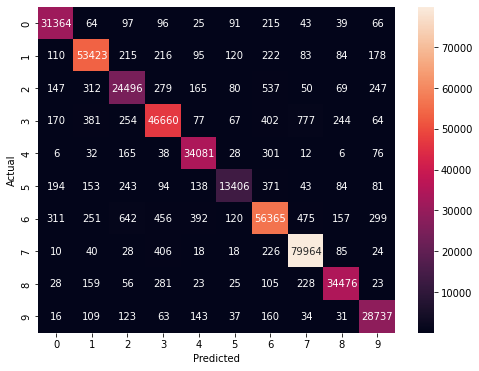

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#classification matrix 확인 
cf_matrix = confusion_matrix(last_test_data['label'], last_test_data['predict'])
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()